Богомолов Владислав ББМО-01-22

Практическая работа 5

# Overview
The notebook shows how the ```lime_image``` tools can be applied to a smaller dataset like mnist. The dataset is very low resolution and allows quite a bit of rapid-iteration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

In [22]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist_data_array=mnist.data.to_numpy(dtype=np.uint8)
# make each image color so lime_image works correctly
x_vec = np.stack([gray2rgb(iimg) for iimg in mnist_data_array.reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

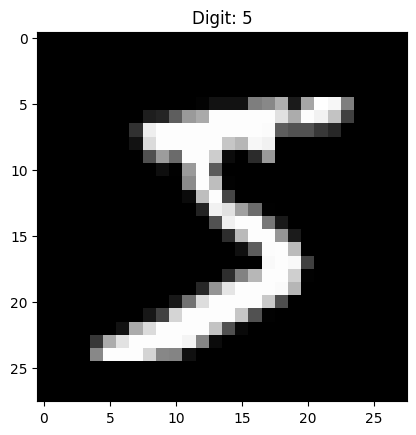

In [23]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(x_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

# Setup a Pipeline
Here we make a pipeline for processing the images where basically we flatten the image back to 1d vectors and then use a RandomForest Classifier

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,x):
        return self._step_func(x)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_vec, y_vec,
                                                    train_size=0.55)

In [26]:
simple_rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7944dd784820>),
                ('Flatten Image', <__main__.PipeStep object at 0x7944dd787b20>),
                ('RF', RandomForestClassifier())])

In [10]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bd694d5602ac343606b349b2554e639cb888fd2e354d5d350b74ec7796daa922
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [27]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [29]:
%%time
explanation = explainer.explain_instance(x_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 9.02 s, sys: 184 ms, total: 9.2 s
Wall time: 9.72 s


Text(0.5, 1.0, 'Positive/Negative Regions for 5')

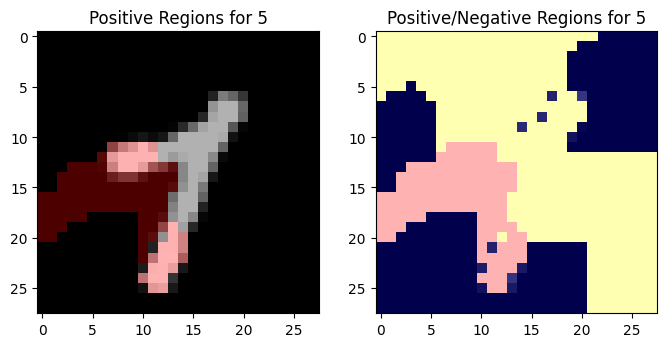

In [30]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

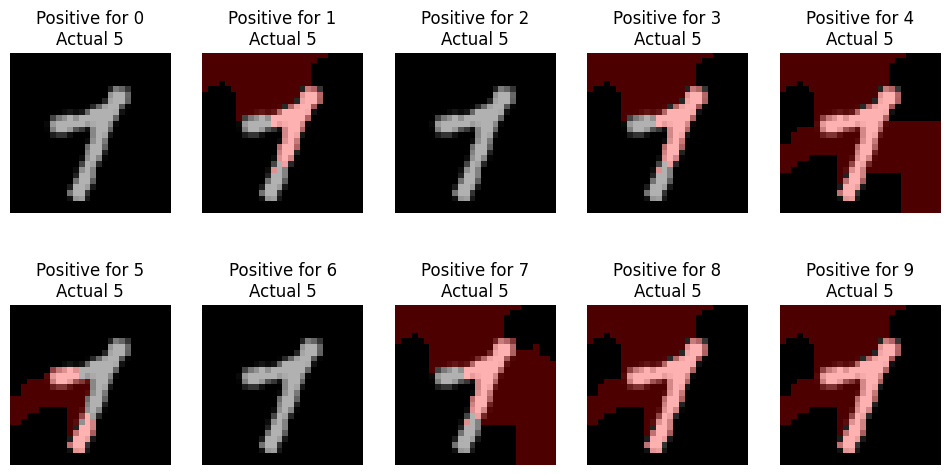

In [31]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,x_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

# Gaining Insight
Can we find an explanation for a classification the algorithm got wrong

In [34]:
from sklearn.pipeline import Pipeline

In [36]:
pipe_pred_test = simple_rf_pipeline.predict(x_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #9327 where the label was 7 and the pipeline predicted 1


In [37]:
%%time
explanation = explainer.explain_instance(x_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.46 s, sys: 145 ms, total: 8.6 s
Wall time: 8.9 s


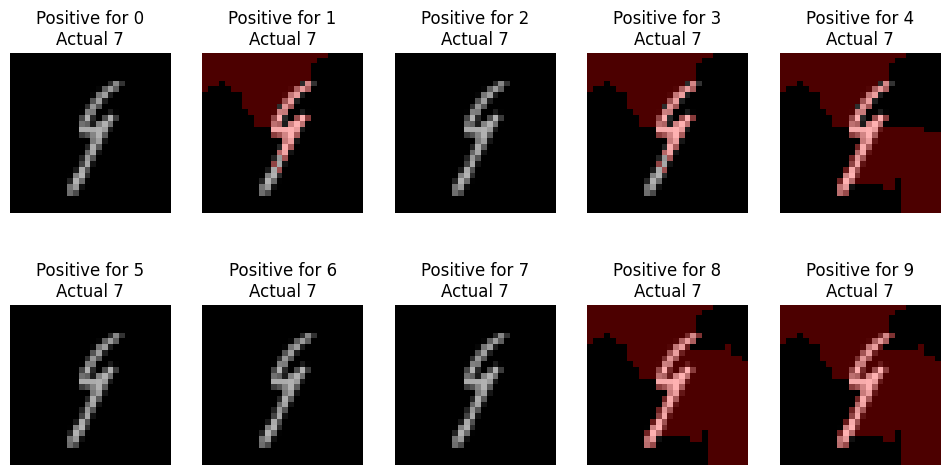

In [38]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')